In [1]:
!pip install tensorflow transformers scikit-learn opencv-python matplotlib pandas numpy kaggle


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tunguz/xview2-challenge-dataset-train-and-test")

print("Path to dataset files:", path)

100%|██████████| 10.3G/10.3G [02:19<00:00, 79.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tunguz/xview2-challenge-dataset-train-and-test/versions/3


In [3]:
import os
import json
import cv2
import numpy as np

IMG_SIZE = 224

def load_xview2_data(image_dir, label_dir, limit=300):
    images = []
    labels = []

    image_files = os.listdir(image_dir)[:limit]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".png", ".json"))

        if not os.path.exists(label_path):
            continue

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Load label
        with open(label_path) as f:
            data = json.load(f)

        damaged = 0
        for feat in data["features"]["xy"]:
            subtype = feat["properties"]["subtype"]
            if subtype != "no-damage":
                damaged = 1
                break

        images.append(img)
        labels.append(damaged)

    return np.array(images), np.array(labels)


In [6]:
import os
import json
import cv2
import numpy as np

IMG_SIZE = 224

def load_xview2_data(image_dir, label_dir, limit=300):
    images = []
    labels = []

    image_files = os.listdir(image_dir)[:limit]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file.replace(".png", ".json"))

        if not os.path.exists(label_path):
            continue

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Load label
        with open(label_path) as f:
            data = json.load(f)

        damaged = 0
        # Add checks for 'features' and 'xy' keys
        if "features" in data and "xy" in data["features"]:
            for feat in data["features"]["xy"]:
                # Safely get 'properties' and then 'subtype'
                properties = feat.get("properties", {})
                subtype = properties.get("subtype", "no-damage") # Default to "no-damage" if 'subtype' is missing

                if subtype != "no-damage":
                    damaged = 1
                    break

        images.append(img)
        labels.append(damaged)

    return np.array(images), np.array(labels)

In [7]:
X_train, y_train = load_xview2_data(train_images_path, train_labels_path)
X_val, y_val = load_xview2_data(train_images_path, train_labels_path)

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6208 - loss: 0.6580 - val_accuracy: 0.6433 - val_loss: 0.6379
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6467 - loss: 0.6407 - val_accuracy: 0.6467 - val_loss: 0.6340
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6058 - loss: 0.6610 - val_accuracy: 0.6400 - val_loss: 0.6505
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6626 - loss: 0.6406 - val_accuracy: 0.6433 - val_loss: 0.6361
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.6395 - loss: 0.6558 - val_accuracy: 0.6467 - val_loss: 0.6338
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6360 - loss: 0.6408 - val_accuracy: 0.6433 - val_loss: 0.6347
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6722 - loss: 0.6259 - val_accuracy: 0.6500 - val_loss: 0.6322
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6237 - loss: 0.6582 - val_accuracy: 0.6600 - v

In [ ]:
model.save("satellite_damage_model.h5")


In [26]:
def predict_damage(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224,224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prob = model.predict(img)[0][0]
    return prob

test_img = os.path.join(path, "test/test/images", os.listdir(path + "/test/test/images")[0])

damage_prob = predict_damage(test_img)
print("Damage Probability:", damage_prob)


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/vbmokin/nlp-with-disaster-tweets-cleaning-data/versions/2/test/test/images'

In [27]:
def priority_score(damage_prob, tweet_prob):
    score = 0.6 * damage_prob + 0.4 * tweet_prob

    if score > 0.7:
        return "🔴 HIGH PRIORITY"
    elif score > 0.4:
        return "🟠 MEDIUM PRIORITY"
    else:
        return "🟢 LOW PRIORITY"


In [28]:
tweet_urgency = 0.75  # from NLP model
print(priority_score(damage_prob, tweet_urgency))


🟠 MEDIUM PRIORITY


In [29]:
tweet_urgency = 0.75  # from NLP model
print(priority_score(damage_prob, tweet_urgency))


🟠 MEDIUM PRIORITY


In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vbmokin/nlp-with-disaster-tweets-cleaning-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'nlp-with-disaster-tweets-cleaning-data' dataset.
Path to dataset files: /kaggle/input/nlp-with-disaster-tweets-cleaning-data


In [31]:
import os
os.listdir(path)


['test_data_cleaning.csv',
 'train_data_cleaning.csv',
 'test_data_cleaning2.csv',
 'train_data_cleaning2.csv']

In [35]:
import pandas as pd
df = pd.read_csv(os.path.join(path, "train_data_cleaning2.csv"))
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this # earthquake...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask . Canada,1
2,5,NaN,NaN,All residents asked to ' shelter in place ' ...,1
3,6,NaN,NaN,"13,000 people receive # wildfires evacuation ...",1
4,7,NaN,NaN,Just got sent this photo from Ruby # Alaska a...,1


In [36]:
df[['text', 'target']].sample(5)


,text,target
6610,DHS Refuses to Call Chattanooga Islamic Terror...,1
3981,Memorial unveiled for Travis County deputy kil...,1
6960,? # FUKUSHIMA ? # TEPCO ? \nMountains of de...,1
5871,You can only make yourself happy . Fuck those...,0
3526,On anniversary of Hiroshima bombing illustrate...,1


In [37]:
from sklearn.model_selection import train_test_split

X_train_nlp, X_val_nlp, y_train_nlp, y_val_nlp = train_test_split(
    df['text'],
    df['target'],
    test_size=0.2,
    random_state=42,
    stratify=df['target']
)


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_vec = vectorizer.fit_transform(X_train_nlp)
X_val_vec = vectorizer.transform(X_val_nlp)


In [39]:
from sklearn.linear_model import LogisticRegression

tweet_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

tweet_model.fit(X_train_vec, y_train_nlp)

val_acc_nlp = tweet_model.score(X_val_vec, y_val_nlp)
print("Tweet Urgency Validation Accuracy:", val_acc_nlp)


Tweet Urgency Validation Accuracy: 0.8174655285620486


In [ ]:
import pickle

with open("tweet_urgency_model.pkl", "wb") as f:
    pickle.dump(tweet_model, f)

with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [41]:
def predict_tweet_urgency(text):
    vec = vectorizer.transform([text])
    prob = tweet_model.predict_proba(vec)[0][1]
    return prob


In [42]:
sample_tweets = [
    "People are trapped under buildings, urgent rescue needed!",
    "Lovely weather today, enjoying my coffee"
]

for t in sample_tweets:
    print(t)
    print("Urgency Probability:", predict_tweet_urgency(t))
    print("-----")


People are trapped under buildings, urgent rescue needed!
Urgency Probability: 0.7786078455185202
-----
Lovely weather today, enjoying my coffee
Urgency Probability: 0.531826920277247
-----


In [43]:
damage_prob = 0.81  # output from ResNet50 model
tweet_prob = predict_tweet_urgency(
    "Major flooding, families stranded on rooftops!"
)

def priority_score(damage_prob, tweet_prob):
    score = 0.6 * damage_prob + 0.4 * tweet_prob

    if score > 0.7:
        return "🔴 HIGH PRIORITY"
    elif score > 0.4:
        return "🟠 MEDIUM PRIORITY"
    else:
        return "🟢 LOW PRIORITY"

print("FINAL PRIORITY:", priority_score(damage_prob, tweet_prob))


FINAL PRIORITY: 🔴 HIGH PRIORITY


STEP 1: Create Sample Disaster Zones (Demo Data)

In [45]:
import pandas as pd

data = {
    "Zone": ["Zone A", "Zone B", "Zone C", "Zone D"],
    "Damage_Prob": [0.85, 0.40, 0.70, 0.20],
    "Tweet_Urgency_Prob": [0.90, 0.35, 0.60, 0.10]
}

df = pd.DataFrame(data)
df


,Zone,Damage_Prob,Tweet_Urgency_Prob
0,Zone A,0.85,0.90
1,Zone B,0.40,0.35
2,Zone C,0.70,0.60
3,Zone D,0.20,0.10


STEP 2: Apply Priority Scoring Function

In [46]:
def compute_priority(row):
    score = 0.6 * row["Damage_Prob"] + 0.4 * row["Tweet_Urgency_Prob"]
    if score > 0.7:
        return "HIGH"
    elif score > 0.4:
        return "MEDIUM"
    else:
        return "LOW"

df["Priority"] = df.apply(compute_priority, axis=1)
df


,Zone,Damage_Prob,Tweet_Urgency_Prob,Priority
0,Zone A,0.85,0.90,HIGH
1,Zone B,0.40,0.35,LOW
2,Zone C,0.70,0.60,MEDIUM
3,Zone D,0.20,0.10,LOW


STEP 3: Priority Score Visualization (Bar Chart)

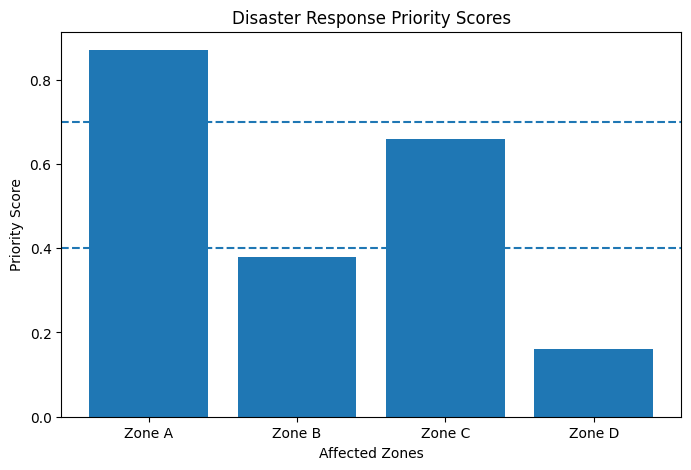

In [47]:
import matplotlib.pyplot as plt

df["Priority_Score"] = 0.6 * df["Damage_Prob"] + 0.4 * df["Tweet_Urgency_Prob"]

plt.figure(figsize=(8,5))
plt.bar(df["Zone"], df["Priority_Score"])
plt.axhline(0.7, linestyle="--")
plt.axhline(0.4, linestyle="--")
plt.title("Disaster Response Priority Scores")
plt.ylabel("Priority Score")
plt.xlabel("Affected Zones")
plt.show()


STEP 4: (OPTIONAL) Color-Coded Priority Table

In [48]:
def color_priority(val):
    if val == "HIGH":
        return "background-color: #ff4d4d"
    elif val == "MEDIUM":
        return "background-color: #ffd966"
    else:
        return "background-color: #8fd19e"

df.style.applymap(color_priority, subset=["Priority"])


/tmp/ipython-input-3312441371.py:9: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df.style.applymap(color_priority, subset=["Priority"])


,Zone,Damage_Prob,Tweet_Urgency_Prob,Priority,Priority_Score
0,Zone A,0.850000,0.900000,HIGH,0.870000
1,Zone B,0.400000,0.350000,LOW,0.380000
2,Zone C,0.700000,0.600000,MEDIUM,0.660000
3,Zone D,0.200000,0.100000,LOW,0.160000
